Building Energy Performance

This Jupyter notebook was made in order to test out different machine learning techniques on an interesting data set. I first ran into this dataset on UC Irvine's machine learning repository.  The dataset was created by Angeliki Xifara and was processed by Athanasios Tsanas.

Quick Overview of the data:

The goal is to perform a regression analysis to predict the energy efficiency of different building types from labeled data.  For the inputs, 12 different building shapes were generated using the application Ecotect.  Then using the application NODEM, simulations were performed to predict the heating and cooling load for each building shape, while also varying three other parameters: orientation, glazing area, and glazing area distribution (the latter two variables describe the enclosure's transparence, provided by windows).  The raw data provided consists of the input data for these simulations, along with their outputs.  However, instead of specifying the exact building shape, five features associated to building shape are given.  They are relative compactness, surface area, wall area, roof area, and overall height.  The purpose of this project is to train a machine learning model which can predict the heating and cooling load for a building type solely based on the eight input features (and not relying on expensive simulations).

The analysis carried out below follows chapter two of Aurélien Géron's Hands-On Machine Learning with Scikit-Learn and TensorFlow.

## Get the Data

We will begin by loading the data into a pandas dataframe.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.set_printoptions(precision=4, suppress=True)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline

buildings = pd.read_csv("ENBtable.csv").dropna()

RC, SA, WA, RA = "Relative Compactness", "Surface Area", "Wall Area", "Roof Area"
OH, O, GA, GAD = "Overall Height", "Orientation", "Glazing Area", "Glazing Area Distribution"
HL, CL = "Heating Load", "Cooling Load"

features, labels = list(buildings)[:8], list(buildings)[8:]
num_feats, cat_feats = features[:5]+[GA], [O, GAD]

categories = ['none', 'uniform', 'north', 'east', 'south', 'west']
converter = lambda k: categories[int(k)]
buildings[cat_feats] = buildings[cat_feats].applymap(converter)
buildings[O] = buildings[O].astype('category')
buildings[GAD] = buildings[GAD].astype('category')

buildings.head()

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load,Cooling Load
0,0.980,514.500,294.000,110.250,7.000,north,0.000,none,15.550,21.330
1,0.980,514.500,294.000,110.250,7.000,east,0.000,none,15.550,21.330
2,0.980,514.500,294.000,110.250,7.000,south,0.000,none,15.550,21.330
3,0.980,514.500,294.000,110.250,7.000,west,0.000,none,15.550,21.330
4,0.900,563.500,318.500,122.500,7.000,north,0.000,none,20.840,28.280


Remember the last two columns make up the labels (they are the "target" variables) while the first eight columns are our building features.  Let's take a closer look at our dataset.

## Analyze the Data

In [2]:
buildings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 768 entries, 0 to 767
Data columns (total 10 columns):
Relative Compactness         768 non-null float64
Surface Area                 768 non-null float64
Wall Area                    768 non-null float64
Roof Area                    768 non-null float64
Overall Height               768 non-null float64
Orientation                  768 non-null category
Glazing Area                 768 non-null float64
Glazing Area Distribution    768 non-null category
Heating Load                 768 non-null float64
Cooling Load                 768 non-null float64
dtypes: category(2), float64(8)
memory usage: 55.9 KB


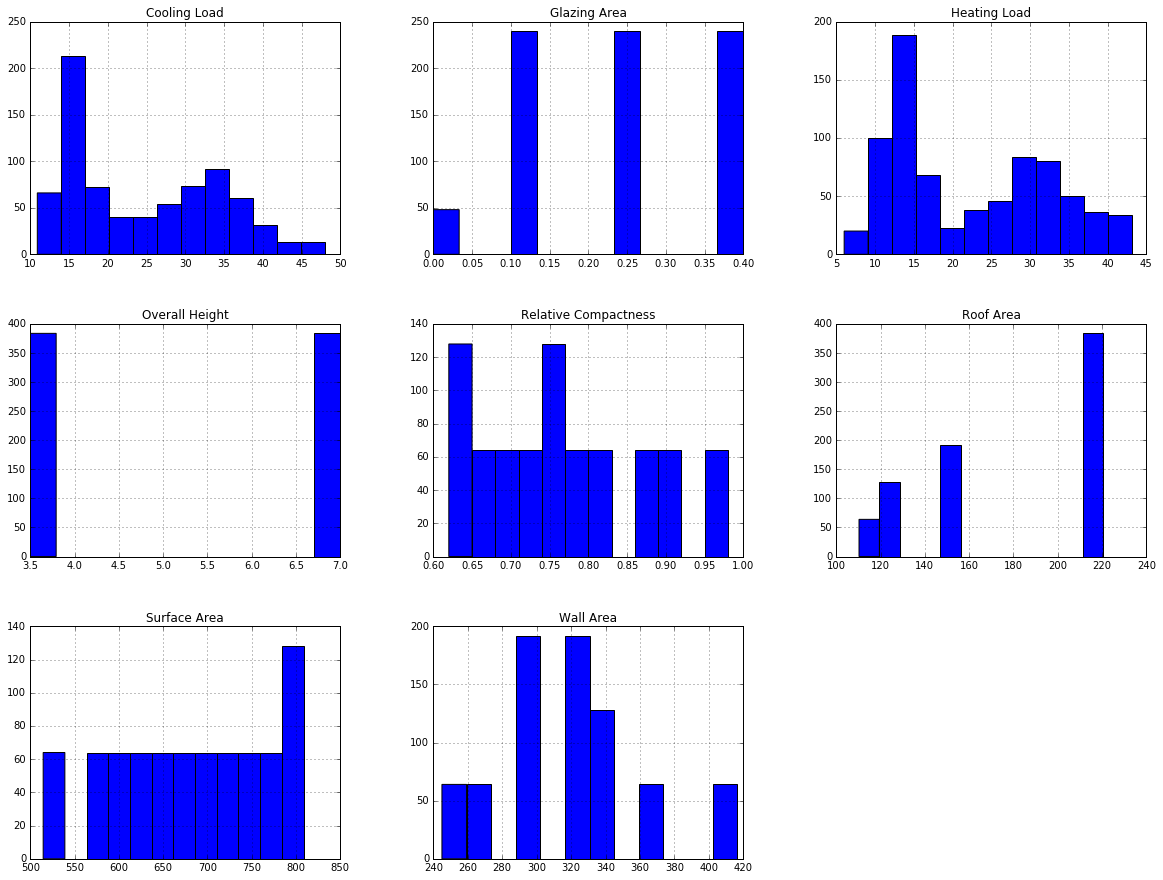

In [3]:
buildings.hist(bins=12, figsize=(20,15))
plt.show()

In [4]:
buildings.groupby([RC, SA, WA, RA, OH]).size()

Relative Compactness  Surface Area  Wall Area  Roof Area  Overall Height
0.620                 808.500       367.500    220.500    3.500             64
0.640                 784.000       343.000    220.500    3.500             64
0.660                 759.500       318.500    220.500    3.500             64
0.690                 735.000       294.000    220.500    3.500             64
0.710                 710.500       269.500    220.500    3.500             64
0.740                 686.000       245.000    220.500    3.500             64
0.760                 661.500       416.500    122.500    7.000             64
0.790                 637.000       343.000    147.000    7.000             64
0.820                 612.500       318.500    147.000    7.000             64
0.860                 588.000       294.000    147.000    7.000             64
0.900                 563.500       318.500    122.500    7.000             64
0.980                 514.500       294.000    110.250    

Here we have grouped the dataset by the five features corresponding to the buildings shape; notice that there are 12 rows.  Each row gives the feature values corresponding to a given building shape.  For instance half the buildings are 3.5m tall and the other half are 7m tall.  For each building shape there are 64 possibilities for the remaining three features.  Therefore our dataset has 12x64=768 rows.

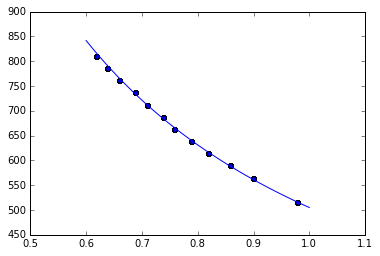

In [5]:
plt.scatter(buildings[RC], buildings[SA])
x = np.linspace(0.6, 1.0)
plt.plot(x, 505/x)
plt.show()

The relative compactness of a building is a unitless quantity equal to 6V^(2/3)/SA, where V is the volume of the unit and SA is the surface area.  The volume of every building was made to be the same, so relative compactness and surface area are inversely proportional as the above graph demonstrates.  We will see that relative compactness is the most important feature for predicting the heating and cooling load.

In [6]:
buildings.groupby([GA, GAD]).size()

Glazing Area  Glazing Area Distribution
0.000         none                         48
0.100         east                         48
              north                        48
              south                        48
              uniform                      48
              west                         48
0.250         east                         48
              north                        48
              south                        48
              uniform                      48
              west                         48
0.400         east                         48
              north                        48
              south                        48
              uniform                      48
              west                         48
dtype: int64

The glazing area is given as a fraction of the floor area, and measures the amount of transparency of the enclosure.  The glazing area distribution indicates how windows tend to be oriented around the building.  This table shows the 16 different possible combinations of glazing area and glazing area distribution appear in this dataset.

In [7]:
buildings[[HL, CL]].std()

Heating Load   10.090
Cooling Load    9.513
dtype: float64

This table shows the overall variance of our target variables.

In [8]:
(buildings[[O, GA, GAD, HL, CL]].groupby([O, GA, GAD]).std()).mean()

Heating Load   10.058
Cooling Load    9.607
dtype: float64

This table shows the average variance of our target variables when orientation, glazing area, and glazing area distribution are known.  As you can see, the variance is still the same indicating these variables on their own give us little information on the target variables.

In [9]:
(buildings[[RC, HL, CL]].groupby(RC).std()).mean()

Heating Load   2.940
Cooling Load   2.472
dtype: float64

On the other hand, relative compactness tells us a lot about the heating and cooling load.  As you can see, when relative compactness is known the variance goes down a bunch.

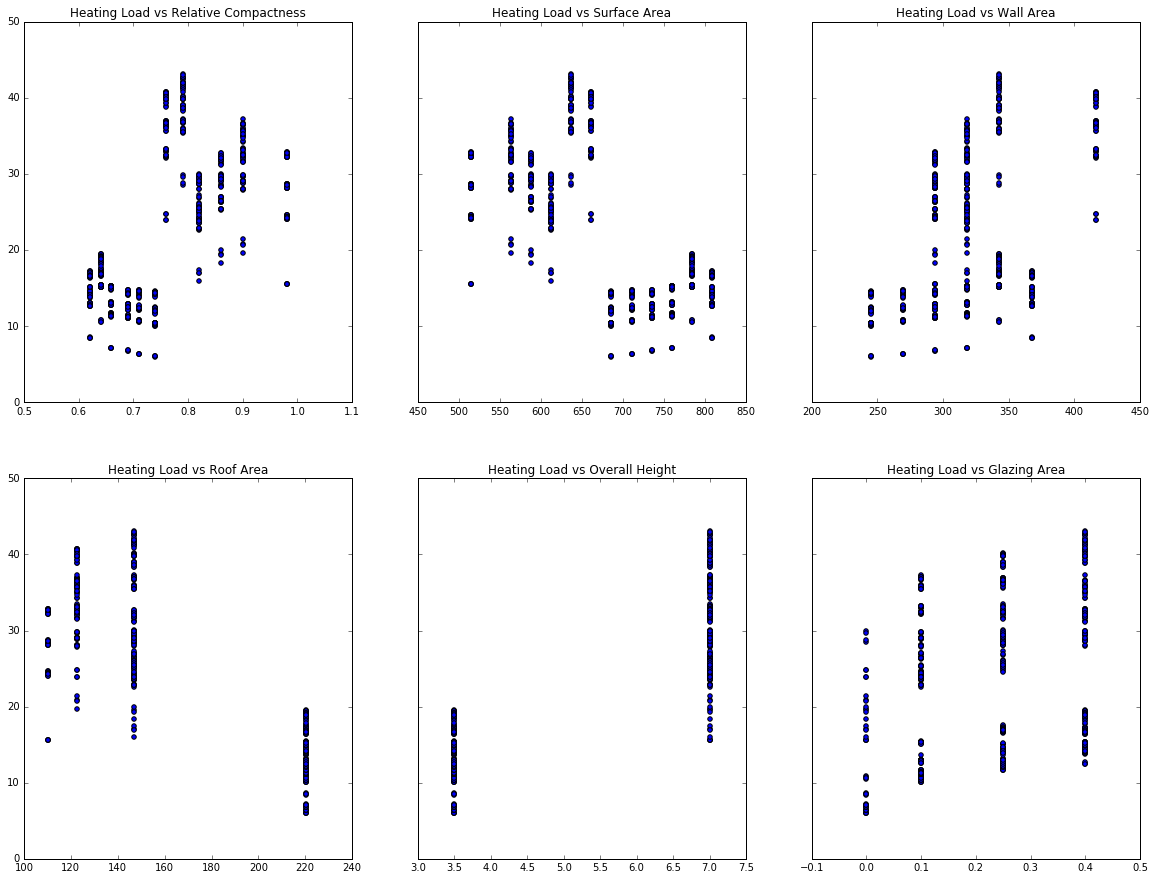

In [10]:
f, axarr = plt.subplots(2, 3, sharey=True, figsize=(20,15))
for i in range(6):
    axarr[i//3, i%3].scatter(buildings[num_feats[i]], buildings[HL])
    axarr[i//3, i%3].set_title("Heating Load vs " + num_feats[i])
plt.show()

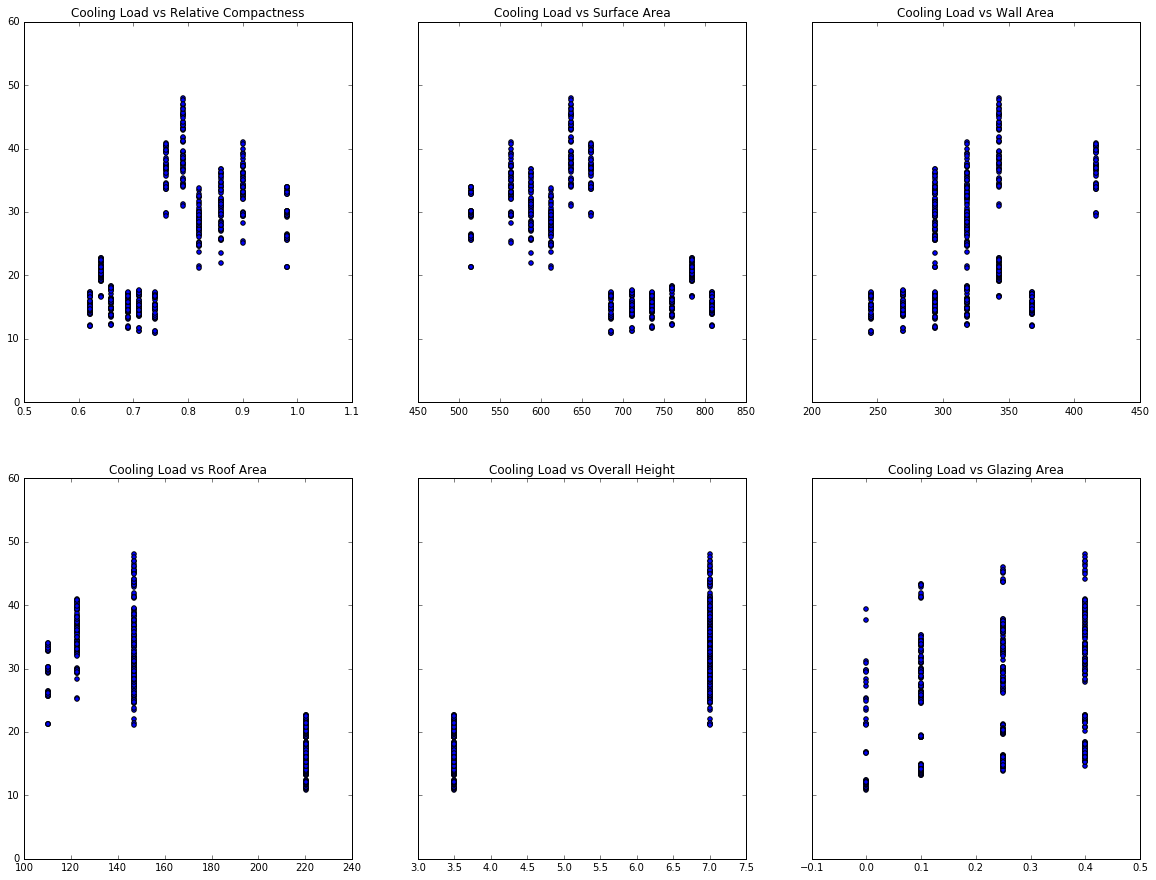

In [11]:
f, axarr = plt.subplots(2, 3, sharey=True, figsize=(20,15))
for i in range(6):
    axarr[i//3, i%3].scatter(buildings[num_feats[i]], buildings[CL])
    axarr[i//3, i%3].set_title("Cooling Load vs " + num_feats[i])
plt.show()

In [12]:
buildings.describe()

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Glazing Area,Heating Load,Cooling Load
count,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000
mean,0.764,671.708,318.500,176.604,5.250,0.234,22.307,24.588
std,0.106,88.086,43.626,45.166,1.751,0.133,10.090,9.513
min,0.620,514.500,245.000,110.250,3.500,0.000,6.010,10.900
25%,0.682,606.375,294.000,140.875,3.500,0.100,12.992,15.620
50%,0.750,673.750,318.500,183.750,5.250,0.250,18.950,22.080
75%,0.830,741.125,343.000,220.500,7.000,0.400,31.668,33.133
max,0.980,808.500,416.500,220.500,7.000,0.400,43.100,48.030


This is just an overall description of the numeric variables.  Now that we've looked at the data, it's time to process it.

## Process the Data

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(buildings, buildings[RC]):
    strat_train_set = buildings.loc[train_index]
    strat_train_set.index = range(614)
    strat_test_set = buildings.loc[test_index]
strat_train_set.head()
#for loop only has one loop because n_splits=1
#len(train_index) = 614
#len(test_index) = 154

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load,Cooling Load
0,0.690,735.000,294.000,220.500,3.500,north,0.250,east,12.340,14.920
1,0.900,563.500,318.500,122.500,7.000,west,0.100,uniform,28.090,34.330
2,0.790,637.000,343.000,147.000,7.000,south,0.100,north,36.970,33.870
3,0.740,686.000,245.000,220.500,3.500,north,0.400,west,14.410,16.690
4,0.690,735.000,294.000,220.500,3.500,east,0.100,west,11.140,14.280


Here we have randomly split the data into a training set and a test set.  We did a stratified split to ensure that the distribution of relative compactness in the training and test sets matches the original distribution (since relative compactness is an important indicator, it's important that none of its possible values is under/over represented).

We should not look at the test set until we've trained a few good models on the training set.

In [14]:
buildings_feats, buildings_labels = strat_train_set[features], strat_train_set[labels]
buildings_num, buildings_cat = buildings_feats[num_feats], buildings_feats[cat_feats]
buildings_feats.head()

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution
0,0.690,735.000,294.000,220.500,3.500,north,0.250,east
1,0.900,563.500,318.500,122.500,7.000,west,0.100,uniform
2,0.790,637.000,343.000,147.000,7.000,south,0.100,north
3,0.740,686.000,245.000,220.500,3.500,north,0.400,west
4,0.690,735.000,294.000,220.500,3.500,east,0.100,west


This table consist of feature data for our training set.

In [15]:
buildings_cat.head(11)

,Orientation,Glazing Area Distribution
0,north,east
1,west,uniform
2,south,north
3,north,west
4,east,west
5,west,south
6,north,east
7,east,uniform
8,east,north
9,west,north


A table consisting of the categorical features in our training data.  We're going to have to convert this into a series of zeroes and ones using Scikit-Learn's OneHotEncoder function.  First we have to convert the categories into integers.

In [16]:
reverter = lambda x: categories.index(x)
buildings_cat_encoded = (np.vectorize(reverter))(buildings_cat.values)
buildings_cat_encoded[:11]

array([[2, 3],
       [5, 1],
       [4, 2],
       [2, 5],
       [3, 5],
       [5, 4],
       [2, 3],
       [3, 1],
       [3, 2],
       [5, 2],
       [2, 0]])

In [17]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(n_values=6)
buildings_cat_1hot = one_hot_encoder.fit_transform(buildings_cat_encoded)
buildings_cat_1hot

<614x12 sparse matrix of type '<class 'numpy.float64'>'
	with 1228 stored elements in Compressed Sparse Row format>

In [18]:
(buildings_cat_1hot.toarray())[:11]

array([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

Our table of categorical features has now been transformed into an array of zeros and ones.  Now we are going to make a pipeline which will perform all the necessary data processing steps at once.  This will be useful to have later when we have to apply the same transformations to the feature data in our test set.

In [19]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

This class can take a dataframe and select the values in a number of specified columns (the attribute names).  We will use this to split our feature data into numeric data and categorical data.

In [20]:
class CatEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = (np.vectorize(reverter))(X)
        return (one_hot_encoder.fit_transform(X)).toarray()

The categorical encoder.  It takes categorical data and transforms it into an array of zeroes and ones as we did above.

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_feats)),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_feats)),
        ('cat_encoder', CatEncoder()),
    ])

The numeric pipeline selects the numeric features and scales the values.  The categorical pipeline selects the categorical data and converts the categories into zeroes and ones.

In [22]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

This puts the two pipelines above together.

In [23]:
buildings_prepared = full_pipeline.fit_transform(buildings_feats)
buildings_prepared.shape

(614, 18)

In [24]:
buildings_prepared[:10,:6]

array([[-0.7049,  0.7223, -0.5618,  0.9756, -1.0033,  0.1192],
       [ 1.2809, -1.2253,  0.0009, -1.1958,  0.9967, -1.0184],
       [ 0.2407, -0.3906,  0.5636, -0.6529,  0.9967, -1.0184],
       [-0.2321,  0.1658, -1.6873,  0.9756, -1.0033,  1.2568],
       [-0.7049,  0.7223, -0.5618,  0.9756, -1.0033, -1.0184],
       [-0.043 , -0.1124,  2.2518, -1.1958,  0.9967,  0.1192],
       [-0.043 , -0.1124,  2.2518, -1.1958,  0.9967,  0.1192],
       [ 0.9027, -0.9471, -0.5618, -0.6529,  0.9967,  0.1192],
       [-1.1777,  1.2788,  0.5636,  0.9756, -1.0033, -1.0184],
       [ 1.2809, -1.2253,  0.0009, -1.1958,  0.9967,  0.1192]])

Our scaled numeric data.

In [25]:
buildings_prepared[:10,6:]

array([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.]])

Our transformed categorical data.

## Training Models

Now we are going to train a few models.  Here I will define an add_regressor function which will take as input a regressor (along with its name) and will train the regressor on the training data using cross validation.  Each regressor is trained to predict both the heating load and the cooling load, so two regressors are made in each application of the add_regressor function.  After training the regressors, add_regressor then stores both regressors in a dictionary for later use.  It also prints a score of both regressors and stores the scores in a score table which can be viewed later to compare different classifiers.

Lastly, one can also pass add_regressor a series of values for the hyperparameters of the model (e.g. learning rate etc.).  add_regressor will use a grid search to find the parameters that work best.

In [26]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

regressors = {HL: {}, CL: {}}
columns = ["Training RMSE", "Cross Validation RMSE", "Cross Validation SD"]
tables = {HL: pd.DataFrame(columns=columns), CL: pd.DataFrame(columns=columns)}

def add_regressor(regressor, name, param_grid=None, data=buildings_prepared,
              targets=buildings_labels):
    for label in targets:
        print(label)
        target = targets[label]
        if param_grid is None:
            best_regressor = regressor
        else:
            grid_search = GridSearchCV(regressor, param_grid, cv=5,
                                       scoring='neg_mean_squared_error')
            grid_search.fit(data, target);
            best_regressor = grid_search.best_estimator_
        best_regressor.fit(data, target)
        predictions = best_regressor.predict(data)
        rmse = np.sqrt(mean_squared_error(target, predictions))
        scores = cross_val_score(best_regressor, data, target,
                         scoring="neg_mean_squared_error", cv=10)
        scores = np.sqrt(-scores)
        regressors[target.name][name] = best_regressor
        values = dict(zip(columns, [rmse, scores.mean(), scores.std()]))
        row = pd.DataFrame(values, index=[name], columns=columns)
        print(row)
        table = tables[target.name].append(row)
        tables[target.name] = table[~table.index.duplicated(keep='last')]

In [27]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
add_regressor(lin_reg, "Linear Regression")

Heating Load
                   Training RMSE  Cross Validation RMSE  Cross Validation SD
Linear Regression          2.760                  2.847                0.208
Cooling Load
                   Training RMSE  Cross Validation RMSE  Cross Validation SD
Linear Regression          3.188                  3.271                0.267


The scores for using a simple linear regression model.  RMSE stands for "root mean squared error".

In [28]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
add_regressor(tree_reg, "Decision Tree")

Heating Load
               Training RMSE  Cross Validation RMSE  Cross Validation SD
Decision Tree          0.000                  0.635                0.076
Cooling Load
               Training RMSE  Cross Validation RMSE  Cross Validation SD
Decision Tree          0.000                  2.513                0.267


Don't let the zero training error fool you.  That means this model might be overfitting the data.  Still, the cross validation errors are lower than the linear regression cv errors.

In [29]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]
add_regressor(forest_reg, "Forest Regression", param_grid)

Heating Load
                   Training RMSE  Cross Validation RMSE  Cross Validation SD
Forest Regression          0.225                  0.607                0.064
Cooling Load
                   Training RMSE  Cross Validation RMSE  Cross Validation SD
Forest Regression          0.003                  1.656                0.261


Those are some small errors!  Looks like this is a pretty good regressor.  Let's try some more models.

In [30]:
from sklearn.linear_model import Lasso

lasso = Lasso()
param_grid = {"alpha": [0.03, 0.1, 0.3, 1]}
add_regressor(lasso, "Lasso", param_grid)

Heating Load
       Training RMSE  Cross Validation RMSE  Cross Validation SD
Lasso          2.805                  2.871                0.217
Cooling Load
       Training RMSE  Cross Validation RMSE  Cross Validation SD
Lasso          3.229                  3.296                0.294


In [31]:
from sklearn.linear_model import ElasticNet

enet = ElasticNet()
param_grid = {"alpha": [0.03, 0.1, 0.3, 1],
              "l1_ratio": list(np.linspace(0.1,0.9,9))}
add_regressor(enet, "Elastic Net", param_grid)

Heating Load
             Training RMSE  Cross Validation RMSE  Cross Validation SD
Elastic Net          2.808                  2.874                0.232
Cooling Load
             Training RMSE  Cross Validation RMSE  Cross Validation SD
Elastic Net          3.232                  3.298                0.308


In [32]:
from sklearn.svm import SVR

svr_lin = SVR(kernel='linear')
param_grid = {"C": [1e0, 1e1, 1e2], "gamma": np.logspace(-2,2,5)}
add_regressor(svr_lin, "Linear SVR", param_grid)

Heating Load
            Training RMSE  Cross Validation RMSE  Cross Validation SD
Linear SVR          2.829                  2.899                0.287
Cooling Load
            Training RMSE  Cross Validation RMSE  Cross Validation SD
Linear SVR          3.299                  3.408                0.367


In [33]:
svr_rbf = SVR(kernel='rbf')
param_grid = {"C": [1e0, 1e1, 1e2], "gamma": np.logspace(-2,2,5)}
add_regressor(svr_rbf, "RBF SVR", param_grid)

Heating Load
         Training RMSE  Cross Validation RMSE  Cross Validation SD
RBF SVR          1.147                  1.583                0.303
Cooling Load
         Training RMSE  Cross Validation RMSE  Cross Validation SD
RBF SVR          1.373                  2.229                0.260


Now let's look at our tables to compare the errors for our regressors.

In [34]:
tables[HL]

,Training RMSE,Cross Validation RMSE,Cross Validation SD
Linear Regression,2.760,2.847,0.208
Decision Tree,0.000,0.635,0.076
Forest Regression,0.225,0.607,0.064
Lasso,2.805,2.871,0.217
Elastic Net,2.808,2.874,0.232
Linear SVR,2.829,2.899,0.287
RBF SVR,1.147,1.583,0.303


In [35]:
tables[CL]

,Training RMSE,Cross Validation RMSE,Cross Validation SD
Linear Regression,3.188,3.271,0.267
Decision Tree,0.000,2.513,0.267
Forest Regression,0.003,1.656,0.261
Lasso,3.229,3.296,0.294
Elastic Net,3.232,3.298,0.308
Linear SVR,3.299,3.408,0.367
RBF SVR,1.373,2.229,0.260


Here we want to compare the cross validation errors.  Looks like the forest regression is our best bet.  One thing we can see from these tables is that it's harder to predict the cooling load than the heating load.

In [36]:
final_models = {label: regressors[label]["Forest Regression"] for label in labels}

## Test the Model

Now we can finally test out our regressor on the test data.  We'll just apply our pipeline from above to the test data to prepare it.  Then we can apply our trained forest regressor to the test features.

In [37]:
test_features = strat_test_set[features]
test_labels = strat_test_set[labels]

test_prepared = full_pipeline.transform(test_features)
final_predictions = {label: final_models[label].predict(test_prepared) for label in labels}

final_mse = {label: mean_squared_error(test_labels[label], final_predictions[label])
            for label in labels}
final_rmse = {label: np.sqrt(final_mse[label]) for label in labels}
print("Heating Load RMSE:", final_rmse[HL])
print("Cooling Load RMSE:", final_rmse[CL])

Heating Load RMSE: 0.516112223106
Cooling Load RMSE: 1.3946597942


Hey not bad!  These are our final scores.  Looks like our forest regressor was able to do a reasonably good job making predictions on the test data.

In [38]:
HL_results = pd.DataFrame({"Predictions": final_predictions[HL], "Actual": test_labels[HL]})
HL_results.index = range(154)
CL_results = pd.DataFrame({"Predictions": final_predictions[CL], "Actual": test_labels[CL]})
CL_results.index = range(154)

In [39]:
HL_results.head(10)

,Actual,Predictions
0,10.070,10.161
1,19.420,19.087
2,10.360,10.449
3,41.090,41.109
4,14.580,14.476
5,7.180,7.279
6,32.670,32.272
7,28.640,28.620
8,40.030,39.059
9,12.820,12.966


In [40]:
CL_results.head(10)

,Actual,Predictions
0,13.210,13.693
1,22.530,21.942
2,13.430,14.058
3,47.010,43.773
4,17.470,16.340
5,12.400,12.751
6,33.060,32.498
7,28.950,29.707
8,37.810,40.295
9,16.030,16.947


Lastly these tables show the predicted heating and cooling load values as compared to the actual (simulated) values.